Setup environment and load the base PyPSA-Earth network for a specified country.


In [18]:
# --- Core imports
import os
import sys
import copy
import logging
import warnings
from os.path import join
from pathlib import Path

# --- Numerical / data
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

# --- Power systems / geospatial
import pypsa
import atlite
from shapely.geometry import Point, box
from shapely.ops import unary_union
import shapely

# Optional plotting (only used in helper plot function)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Optional: powerplantmatching (picks up config but we keep local CSV as source of truth)
try:
    import powerplantmatching as pm
    HAVE_PPM = True
except Exception:
    HAVE_PPM = False

# --- Silence noisy warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.filterwarnings('ignore')


# --- Logging
parent_dir = Path(os.getcwd()).parents[0]          # project/
LOG_FILE = join(parent_dir, "logs.log")
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    handlers=[logging.FileHandler(LOG_FILE, encoding="utf-8"), logging.StreamHandler(sys.stdout)],
)
logger = logging.getLogger(__name__)

# --- Project paths helper
sys.path.append(str(parent_dir))
from src.paths import all_dirs  # must exist in your repo
dirs = all_dirs()

# --- Add PyPSA-Earth scripts to PATH (assumes repo layout: <project>/../pypsa-earth/scripts)
scripts_path = os.path.join(parent_dir.parents[0], "pypsa-earth", "scripts")
assert os.path.isdir(scripts_path), f"Path not found: {scripts_path}"
sys.path.append(scripts_path)


In [26]:
# 7) GADM regions and bus mapping (with nearest-region fallback)
COUNTRY_ISO3 = "ECU"
GADM_VERSION = "4.1"
GADM_FILE_STEM = f"gadm41_{COUNTRY_ISO3}"
GADM_URL = f"https://geodata.ucdavis.edu/gadm/gadm{GADM_VERSION}/gpkg/{GADM_FILE_STEM}.gpkg"

def ensure_gadm_file(gadm_path: str) -> str:
    gpkg_path = os.path.join(gadm_path, f"{GADM_FILE_STEM}.gpkg")
    gpkg_dir = Path(gpkg_path).parent
    if not Path(gpkg_path).is_file():
        gpkg_dir.mkdir(parents=True, exist_ok=True)
        import requests, shutil as _shutil
        logger.info(f"Downloading GADM: {GADM_URL}")
        resp = requests.get(GADM_URL, stream=True, timeout=300)
        resp.raise_for_status()
        with open(gpkg_path, "wb") as f:
            _shutil.copyfileobj(resp.raw, f)
    assert Path(gpkg_path).is_file(), f"GADM not found or failed to download: {gpkg_path}"
    return gpkg_path

try:
    gadm_file = ensure_gadm_file(dirs["data/raw/gadm"])
    shapefile = gpd.read_file(gadm_file, layer="ADM_ADM_1")
except Exception as e:
    shapefile = None
    logger.warning(f"Could not load GADM: {e}")




In [28]:

# ======================================================================
#                      8) Atlite resources (wind/PV) per province
# ======================================================================
# CRS for area calculation
AREA_CRS = 6933  # equal-area projection used in your notes
geo_crs = 4326  # g
# Load atlite cutout (expected path)
cutout_path = join(dirs["data/raw/cutouts"], "cutout-2013-era5.nc")
assert os.path.isfile(cutout_path), f"Atlite cutout not found: {cutout_path}"
cutout = atlite.Cutout(cutout_path)


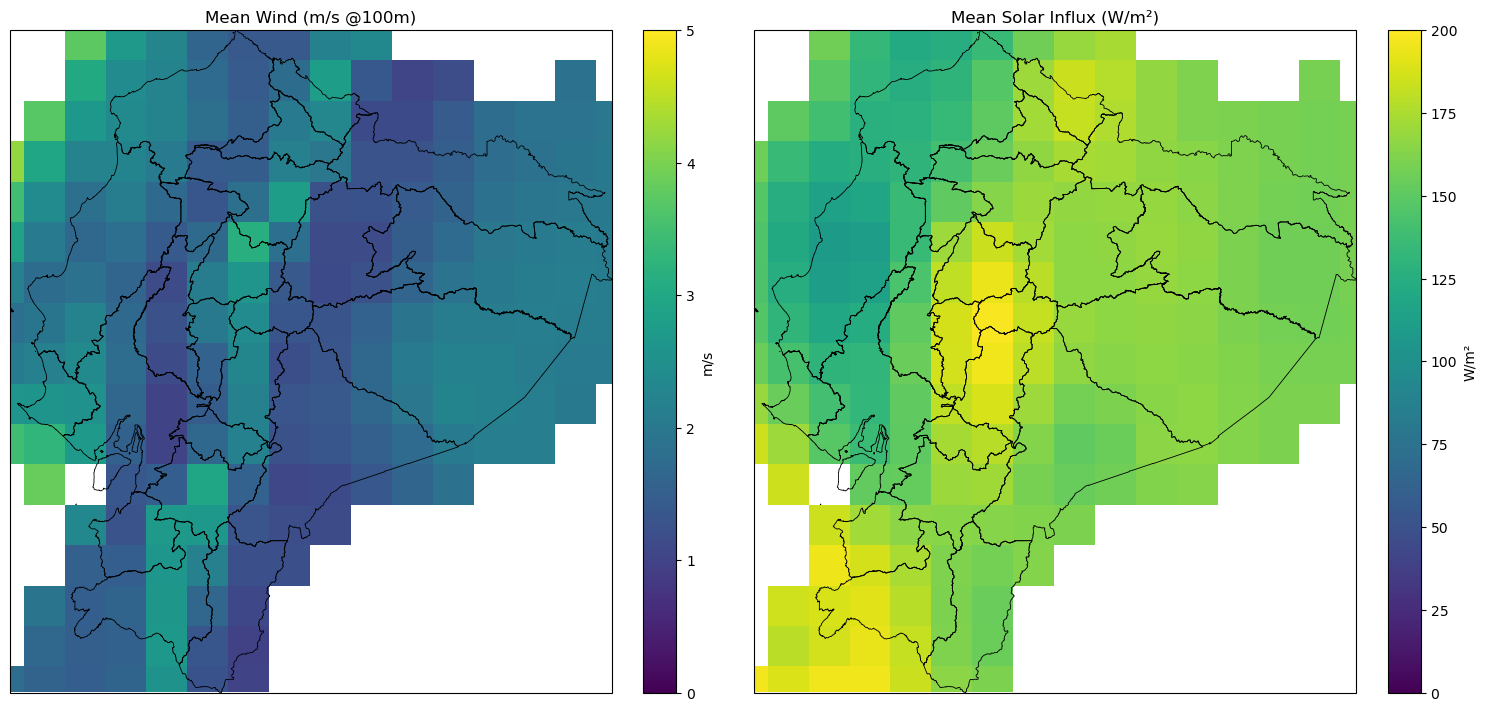

<Figure size 640x480 with 0 Axes>

In [34]:
# ================== FAST, NON-CLUSTERED MAINLAND MAPS ==================
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.ops import unary_union
from shapely.geometry import Point, box

def fast_wind_pv_maps_like_xarray(shapefile_gdf, cutout_obj, time_step=6, coarsen_xy=4):
    """
    Mainland-only mean maps for wind@100m and solar influx, plotted fast (imshow).
    - time_step: take every Nth timestep (e.g. 6 -> ~6x faster)
    - coarsen_xy: spatial coarsening factor (4 is a good default)
    """
    ds = cutout_obj.data[["wnd100m", "influx_direct", "influx_diffuse"]]
    X = "x" if "x" in ds.coords else ("lon" if "lon" in ds.coords else None)
    Y = "y" if "y" in ds.coords else ("lat" if "lat" in ds.coords else None)
    assert X and Y, f"Couldn't find spatial coords. Have: {list(ds.coords)}"

    # Mainland only (exclude Galápagos by centroid longitude)
    shp_geo = shapefile_gdf.to_crs(4326)
    continental = shp_geo[shp_geo.geometry.centroid.x > -85]
    minx, miny, maxx, maxy = continental.total_bounds
    mainland_geom = unary_union(continental.geometry)

    # Crop first (huge speedup)
    xslice = slice(minx, maxx) if ds[X][0] < ds[X][-1] else slice(maxx, minx)
    yslice = slice(miny, maxy) if ds[Y][0] < ds[Y][-1] else slice(maxy, miny)
    ds = ds.sel({X: xslice, Y: yslice})

    # Thin time and (optionally) coarsen spatially
    if time_step and time_step > 1:
        ds = ds.isel(time=slice(None, None, time_step)).astype("float32")
    if coarsen_xy and coarsen_xy > 1:
        ds = ds.coarsen({X: coarsen_xy, Y: coarsen_xy}, boundary="trim").mean()

    # Compute means
    wnd100m = ds["wnd100m"].mean(dim="time").compute()
    influx  = (ds["influx_direct"].mean(dim="time") + ds["influx_diffuse"].mean(dim="time")).compute()

    # Build grid edges from centers for an accurate extent
    def _edges_from_centers(c):
        c = np.asarray(c, dtype=float)
        d = np.diff(c)
        e = np.empty(c.size + 1, dtype=float)
        e[1:-1] = c[:-1] + d/2
        e[0]     = c[0]  - d[0]/2
        e[-1]    = c[-1] + d[-1]/2
        return e

    x_cent = wnd100m[X].values
    y_cent = wnd100m[Y].values
    x_edges = _edges_from_centers(x_cent)
    y_edges = _edges_from_centers(y_cent)
    EXTENT_EXTRA =1 
    extent = (x_edges[0]-EXTENT_EXTRA, x_edges[-1]+EXTENT_EXTRA, 
              y_edges[0]-EXTENT_EXTRA, y_edges[-1]+EXTENT_EXTRA)

    # Fast mask by point-in-polygon on centers (vectorized when available)
    try:
        from shapely import vectorized as shvec  # Shapely >=1.8/2.0
        XX, YY = np.meshgrid(x_cent, y_cent)
        center_mask = shvec.contains(mainland_geom, XX, YY)
    except Exception:
        # Fallback (still fast enough for coarsened grids)
        XX, YY = np.meshgrid(x_cent, y_cent)
        center_mask = np.zeros_like(XX, dtype=bool)
        # Simple bounding-box test first to skip far cells
        minbx, minby, maxbx, maxby = minx, miny, maxx, maxy
        in_bbox = (XX >= minbx) & (XX <= maxbx) & (YY >= minby) & (YY <= maxby)
        jj, ii = np.where(in_bbox)
        for j, i in zip(jj, ii):
            center_mask[j, i] = mainland_geom.contains(Point(float(XX[j, i]), float(YY[j, i])))

    wind_vals  = np.where(center_mask, wnd100m.values, np.nan)
    solar_vals = np.where(center_mask, influx.values,   np.nan)

    # Nice, fast plotting with imshow (PlateCarree)
    max_wind  = np.nanmax(wind_vals);  vmax_w = int(np.ceil(max_wind))
    max_solar = np.nanmax(solar_vals); vmax_s = int(np.ceil(max_solar / 10) * 10)

    fig, ax = plt.subplots(
        1, 2, subplot_kw={'projection': ccrs.PlateCarree()},
        figsize=(15, 7), constrained_layout=True
    )

    im0 = ax[0].imshow(
        wind_vals, origin="lower", extent=extent, transform=ccrs.PlateCarree(),
        vmin=0, vmax=vmax_w, interpolation="nearest"  # 'nearest' is fast; change to 'bilinear' if you prefer
    )
    continental.plot(ax=ax[0], edgecolor="k", facecolor="none", linewidth=0.6)
    ax[0].set_title("Mean Wind (m/s @100m)")
    plt.colorbar(im0, ax=ax[0], label="m/s")
    ax[0].set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())

    im1 = ax[1].imshow(
        solar_vals, origin="lower", extent=extent, transform=ccrs.PlateCarree(),
        vmin=0, vmax=vmax_s, interpolation="nearest"
    )
    continental.plot(ax=ax[1], edgecolor="k", facecolor="none", linewidth=0.6)
    ax[1].set_title("Mean Solar Influx (W/m²)")
    plt.colorbar(im1, ax=ax[1], label="W/m²")
    ax[1].set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())

    plt.show()

    return wind_vals, solar_vals

# Example:
if shapefile is not None:
    wind_vals, solar_vals = fast_wind_pv_maps_like_xarray(shapefile, cutout, time_step=6, coarsen_xy=1)
    FIGS_DIR = dirs["results/graphs"]
    os.makedirs(FIGS_DIR, exist_ok=True)
    out = os.path.join(FIGS_DIR, "RE_EC_Wind_Solar_Resource_Data")
    plt.savefig(out, dpi=600, bbox_inches="tight")



In [30]:
# 9- Plot the Capacities
# Compute grid cell area (km^2)
area = cutout.grid.to_crs(AREA_CRS).area / 1e6
area = xr.DataArray(area.values.reshape(cutout.shape), [cutout.coords["y"], cutout.coords["x"]])

# Province shapes indexed by NAME_1
if shapefile is not None:
    shape_by_prov = shapefile.to_crs("EPSG:4326").set_index("NAME_1")
else:
    shape_by_prov = None
    logger.warning("Shapefile missing; skipping atlite resource aggregation to provinces.")

# Resource configuration
resources_cfg = [
    {"method": "wind", "resource": "onwind", "turbine": "Vestas_V112_3MW", "capacity_per_sqkm": 4.6},
    {"method": "pv",   "resource": "solar",  "panel": "CSi", "orientation": "latitude_optimal", "capacity_per_sqkm": 2.0},
]
correction_factor = 1.0

datasets = {}
capacities = {}

if shape_by_prov is not None:
    for res in resources_cfg:
        method = res["method"]
        res_key = res["resource"]
        profile_path = join(dirs["data/raw/cutouts"], f"{res_key}.nc")

        if Path(profile_path).is_file():
            # Reuse cached dataset
            ds = xr.open_dataset(profile_path)
            datasets[res_key] = ds
            capacities[method] = ds["capacities"]
            logger.info(f"Profile found and loaded: {profile_path}")
            continue

        # Build kwargs for atlite call
        kwargs = {k: v for k, v in res.items() if k not in {"method", "resource", "capacity_per_sqkm"}}
        cap_per_sqkm = float(res["capacity_per_sqkm"])

        # Compute capacity factors quickly on the full cutout
        logger.info(f"Computing {method} capacity factors and capacities (this may take a while)…")
        func = getattr(cutout, method)
        cf = correction_factor * func(capacity_factor=True, **kwargs)

        # Layout proportional to CF * area * cap density
        layout = cf * area * cap_per_sqkm

        # Aggregate by province polygons
        profile, capacity = func(
            shapes=shape_by_prov,
            per_unit=True,
            return_capacity=True,
            layout=layout,
            **kwargs,
        )

        # Store
        capacities[method] = capacity
        ds = xr.Dataset(
            {"profile": profile.rename({"NAME_1": "bus"}),
             "capacities": capacity.rename({"NAME_1": "bus"})}
        )
        ds.to_netcdf(profile_path)
        datasets[res_key] = ds
        logger.info(f"Wrote {profile_path}")



2025-11-10 16:52:02: Profile found and loaded: c:\Repositories\Repos\pypsa-earth-project\EcuadorElectricGrid\data\raw\cutouts\onwind.nc
2025-11-10 16:52:02: Profile found and loaded: c:\Repositories\Repos\pypsa-earth-project\EcuadorElectricGrid\data\raw\cutouts\solar.nc


In [32]:
# ---------------- Harmonize to a single GeoDataFrame ----------------
if shapefile is not None:
    shp_geo = shapefile.to_crs("EPSG:4326").copy()
    # Exclude Galápagos by name OR longitude (belt-and-suspenders)
    shp_geo = shp_geo[~shp_geo["NAME_1"].str.contains("Gal", case=False, na=False)]
    shp_geo = shp_geo[shp_geo.geometry.centroid.x > -85]
    shape_by_prov = shp_geo.set_index("NAME_1")
else:
    shape_by_prov = None
    logger.warning("Shapefile missing; skipping atlite aggregation.")

# Base GDF with areas in km²
cap_gdf = shp_geo.to_crs(AREA_CRS).copy().set_index("NAME_1")
cap_gdf["area_km2"] = (cap_gdf.geometry.area / 1e6).round(2)

# Helpers to pull series from memory/cached datasets
def series_from(cap_key: str, ds_key: str, var: str = "capacities") -> pd.Series:
    """
    Return a pandas Series indexed by province (NAME_1) from either:
    - capacities[cap_key] (xarray DataArray), or
    - datasets[ds_key][var] (xarray DataArray)
    """
    if cap_key in capacities and hasattr(capacities[cap_key], "to_pandas"):
        s = capacities[cap_key].to_pandas()
    else:
        s = datasets[ds_key][var].to_pandas()
    s.name = cap_key
    return s

def cf_mean_series(ds_key: str) -> pd.Series:
    """
    Mean capacity factor per province from cached profile (0..1).
    """
    if ds_key not in datasets:
        raise KeyError(f"Dataset '{ds_key}' not found; cannot compute CF mean.")
    if "profile" not in datasets[ds_key]:
        raise KeyError(f"Dataset '{ds_key}' lacks 'profile'; cannot compute CF mean.")
    cf_mean = datasets[ds_key]["profile"].mean(dim="time").to_pandas()
    cf_mean.name = f"{ds_key}_cf_mean"
    return cf_mean

# Load CF-weighted (equivalent MW) series from cache
mw_eq_wind = series_from("wind", "onwind", var="capacities").astype(float)
mw_eq_pv   = series_from("pv",   "solar",  var="capacities").astype(float)

# Get province-level mean CF (0..1)
cf_wind = cf_mean_series("onwind")
cf_pv   = cf_mean_series("solar")

# Align to province index and avoid division by zero
mw_eq_wind = mw_eq_wind.reindex(cap_gdf.index)
mw_eq_pv   = mw_eq_pv.reindex(cap_gdf.index)
cf_wind    = cf_wind.reindex(cap_gdf.index)
cf_pv      = cf_pv.reindex(cap_gdf.index)

# Replace impossible/zero CF with NaN to prevent division errors
cf_wind = cf_wind.mask(~np.isfinite(cf_wind) | (cf_wind <= 0))
cf_pv   = cf_pv.mask(~np.isfinite(cf_pv) | (cf_pv   <= 0))

# Convert to installed capacity (MW) = equivalent_MW / mean_CF
cap_gdf["wind"] = (mw_eq_wind / cf_wind).astype(float)
cap_gdf["pv"]   = (mw_eq_pv   / cf_pv).astype(float)

# Per-km² metrics (MW per km²)
cap_gdf["wind_per_sqkm"] = (cap_gdf["wind"] / cap_gdf["area_km2"]).replace([np.inf, -np.inf], np.nan)
cap_gdf["pv_per_sqkm"]   = (cap_gdf["pv"]   / cap_gdf["area_km2"]).replace([np.inf, -np.inf], np.nan)

# Optional sanity logs
if 'logger' in globals():
    n_nan_w = cap_gdf["wind"].isna().sum()
    n_nan_p = cap_gdf["pv"].isna().sum()
    logger.info(
        f"Harmonized provinces (Galápagos excluded): {len(cap_gdf)}. "
        f"NaN installed wind={n_nan_w}, NaN installed pv={n_nan_p}."
    )
    if (cap_gdf["wind_per_sqkm"].median(skipna=True) > 10) or (cap_gdf["pv_per_sqkm"].median(skipna=True) > 5):
        logger.warning("Per-km² medians look high; verify province masking and cutout CRS/extent.")

# Final view
cap_gdf[['area_km2', 'wind', 'pv', 'wind_per_sqkm', 'pv_per_sqkm']]

cap_gdf.to_csv(
    join(dirs["data/processed/generation"              ],
         "renewable_energy_generation.csv")
)


2025-11-10 16:52:02: Harmonized provinces (Galápagos excluded): 23. NaN installed wind=0, NaN installed pv=0.


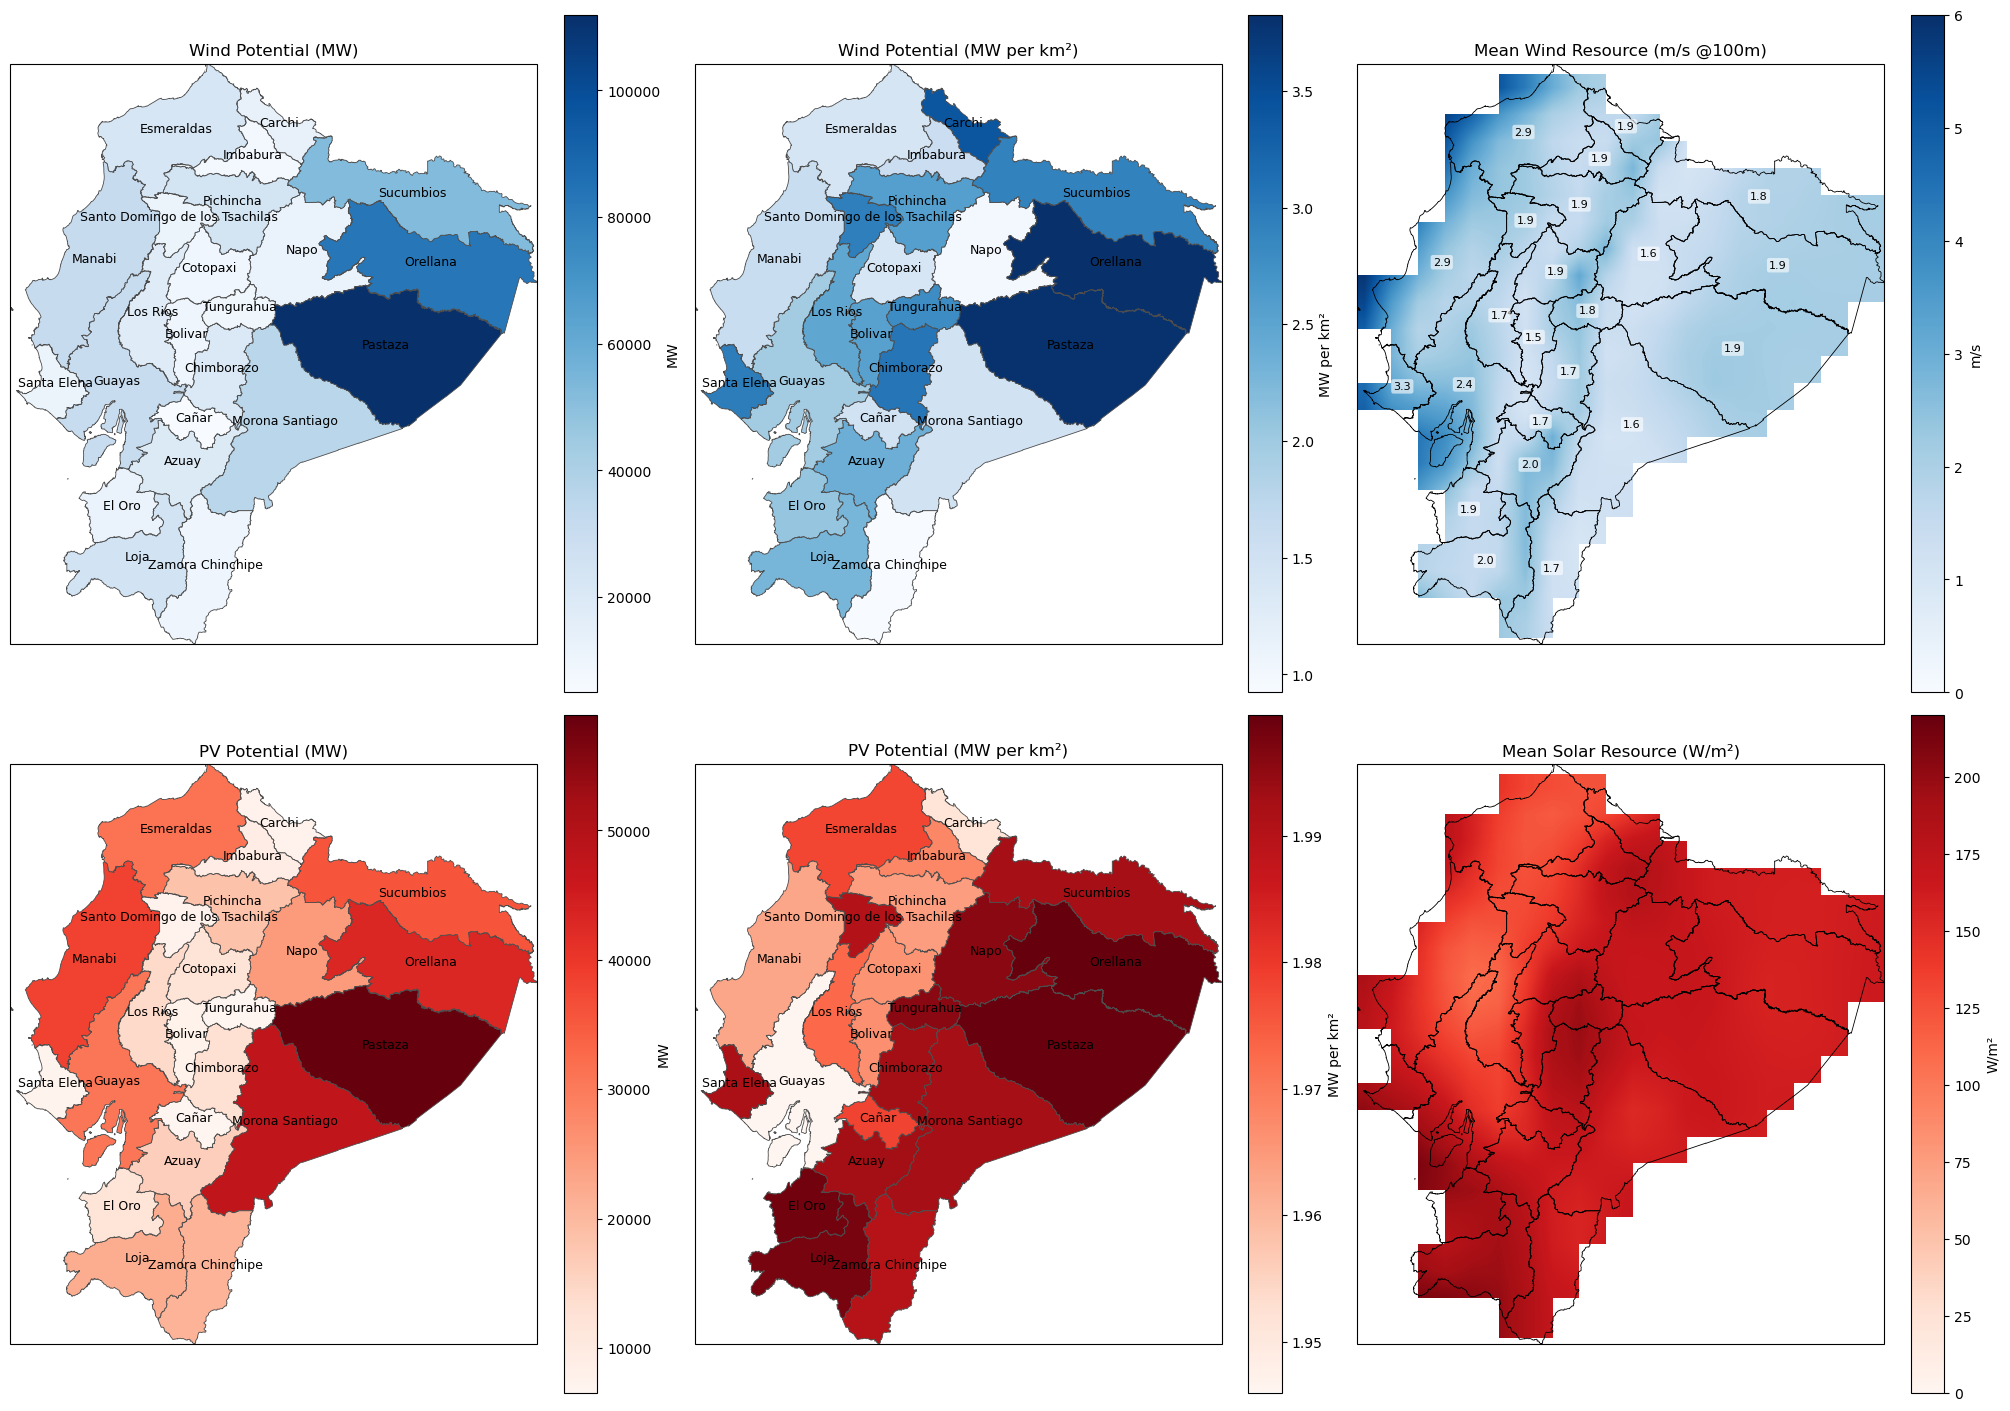

In [ ]:
# ======================= 6-panel wind/PV figure (revised) =======================
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
from shapely.ops import unary_union
from shapely.geometry import box

# --- Prep mainland provinces (EPSG:4326 for plotting) ---
shp_geo = shapefile.to_crs(4326).copy()
continental = shp_geo[(~shp_geo["NAME_1"].str.contains("Gal", case=False, na=False)) &
                      (shp_geo.geometry.centroid.x > -86)]
minx, miny, maxx, maxy = continental.total_bounds

# Annotate positions from province centroids
centroids = continental.geometry.centroid
ann_x = centroids.x.values
ann_y = centroids.y.values
ann_names = continental["NAME_1"].values

# --- Fast resource rasters (mean wind@100m and solar influx) ---
ds = cutout.data[["wnd100m", "influx_direct", "influx_diffuse"]]
X = "x" if "x" in ds.coords else ("lon" if "lon" in ds.coords else None)
Y = "y" if "y" in ds.coords else ("lat" if "lat" in ds.coords else None)
assert X and Y, f"Couldn't find spatial coords. Have: {list(ds.coords)}"

# Crop to mainland bbox
xslice = slice(minx, maxx) if ds[X][0] < ds[X][-1] else slice(maxx, minx)
yslice = slice(miny, maxy) if ds[Y][0] < ds[Y][-1] else slice(maxy, miny)
ds_sub = ds.sel({X: xslice, Y: yslice})

# --- IMPORTANT CHANGES ---
# 1) No spatial coarsening (coarsen_xy = 1); keep every 6th timestep to stay quick.
ds_sub = ds_sub.isel(time=slice(None, None, 6)).astype("float32")

# Compute means
wnd_mean = ds_sub["wnd100m"].mean(dim="time").compute()  # m/s @100m
sol_mean = (ds_sub["influx_direct"].mean(dim="time") + ds_sub["influx_diffuse"].mean(dim="time")).compute()  # W/m²

# Build edges from centers to set extent nicely
def _edges_from_centers(c):
    c = np.asarray(c, dtype=float)
    d = np.diff(c)
    e = np.empty(c.size + 1, dtype=float)
    e[1:-1] = c[:-1] + d/2
    e[0]     = c[0]  - d[0]/2
    e[-1]    = c[-1] + d[-1]/2
    return e

x_cent = wnd_mean[X].values
y_cent = wnd_mean[Y].values
x_edges = _edges_from_centers(x_cent)
y_edges = _edges_from_centers(y_cent)
extent = (x_edges[0], x_edges[-1], y_edges[0], y_edges[-1])

# 2) Switch masking to CELL-POLYGON INTERSECTION (more accurate on coasts)
mainland_geom = unary_union(continental.geometry)
mask = np.zeros((len(y_cent), len(x_cent)), dtype=bool)
for j in range(len(y_cent)):
    y0, y1 = y_edges[j], y_edges[j+1]
    for i in range(len(x_cent)):
        x0, x1 = x_edges[i], x_edges[i+1]
        cell = box(x0, y0, x1, y1)
        mask[j, i] = cell.intersects(mainland_geom)

wind_vals  = np.where(mask, wnd_mean.values, np.nan)
solar_vals = np.where(mask, sol_mean.values,   np.nan)

# Color scale maxima (rounded nicely)
vmax_w = int(np.ceil(np.nanmax(wind_vals)))
vmax_s = int(np.ceil(np.nanmax(solar_vals) / 10) * 10)

# --- 3) Province mean wind speed computed directly from the raster via polygon masks ---
#    (equal-area cells assumed within the cutout CRS; here we just average the kept pixels)
prov_mean_wind = {}
for name, geom in zip(continental["NAME_1"].values, continental.geometry.values):
    # per-province mask (intersects)
    pmask = np.zeros_like(mask, dtype=bool)
    for j in range(len(y_cent)):
        y0, y1 = y_edges[j], y_edges[j+1]
        for i in range(len(x_cent)):
            if not mask[j, i]:
                continue
            x0, x1 = x_edges[i], x_edges[i+1]
            cell = box(x0, y0, x1, y1)
            if cell.intersects(geom):
                pmask[j, i] = True
    vals = wnd_mean.values[pmask]
    prov_mean_wind[name] = float(np.nanmean(vals)) if vals.size else np.nan

# --- Get province-level capacities from cap_gdf (already in MW / MW per km²) ---
cap_plot = cap_gdf.to_crs(4326)  # ensure same CRS as continental for plotting

# --- Create figure and axes ---
fig, ax = plt.subplots(
    nrows=2, ncols=3, figsize=(20, 14),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=True
)

# ---------------- Row 1: WIND ----------------
# (1,1) Wind potential (MW)
cap_plot.plot(ax=ax[0, 0], column="wind", cmap="Blues", legend=True,
              edgecolor="0.3", linewidth=0.6, legend_kwds={"label": "MW"})
ax[0, 0].set_title("Wind Potential (MW)")
for x, y, name in zip(ann_x, ann_y, ann_names):
    ax[0, 0].annotate(name, xy=(x, y), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0, 0]),
                      fontsize=9, ha='center')
ax[0, 0].set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())

# (1,2) Wind potential per km² (MW/km²)
cap_plot.plot(ax=ax[0, 1], column="wind_per_sqkm", cmap="Blues", legend=True,
              edgecolor="0.3", linewidth=0.6, legend_kwds={"label": "MW per km²"})
ax[0, 1].set_title("Wind Potential (MW per km²)")
for x, y, name in zip(ann_x, ann_y, ann_names):
    ax[0, 1].annotate(name, xy=(x, y), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0, 1]),
                      fontsize=9, ha='center')
ax[0, 1].set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())

# (1,3) Wind resource raster (m/s @100m) — bilinear interpolation for smoother comparison
im_w = ax[0, 2].imshow(
    wind_vals, origin="lower", extent=extent, transform=ccrs.PlateCarree(),
    vmin=0, vmax=vmax_w, cmap="Blues", interpolation="bilinear"
)
continental.boundary.plot(ax=ax[0, 2], edgecolor="k", linewidth=0.6)
ax[0, 2].set_title("Mean Wind Resource (m/s @100m)")
plt.colorbar(im_w, ax=ax[0, 2], label="m/s")
# annotate province mean wind (computed from polygons) to compare with raster visually
for x, y, name in zip(ann_x, ann_y, ann_names):
    m = prov_mean_wind.get(name, np.nan)
    if np.isfinite(m):
        ax[0, 2].annotate(f"{m:.1f}", xy=(x, y),
                          xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0, 2]),
                          fontsize=8, ha='center', va='center',
                          bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6, lw=0))
ax[0, 2].set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())

# ---------------- Row 2: SOLAR ----------------
# (2,1) PV potential (MW)
cap_plot.plot(ax=ax[1, 0], column="pv", cmap="Reds", legend=True,
              edgecolor="0.3", linewidth=0.6, legend_kwds={"label": "MW"})
ax[1, 0].set_title("PV Potential (MW)")
for x, y, name in zip(ann_x, ann_y, ann_names):
    ax[1, 0].annotate(name, xy=(x, y), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1, 0]),
                      fontsize=9, ha='center')
ax[1, 0].set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())

# (2,2) PV potential per km² (MW/km²)
cap_plot.plot(ax=ax[1, 1], column="pv_per_sqkm", cmap="Reds", legend=True,
              edgecolor="0.3", linewidth=0.6, legend_kwds={"label": "MW per km²"})
ax[1, 1].set_title("PV Potential (MW per km²)")
for x, y, name in zip(ann_x, ann_y, ann_names):
    ax[1, 1].annotate(name, xy=(x, y), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1, 1]),
                      fontsize=9, ha='center')
ax[1, 1].set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())

# (2,3) Solar resource raster (W/m²) — bilinear interpolation
im_s = ax[1, 2].imshow(
    solar_vals, origin="lower", extent=extent, transform=ccrs.PlateCarree(),
    vmin=0, vmax=vmax_s, cmap="Reds", interpolation="bilinear"
)
continental.boundary.plot(ax=ax[1, 2], edgecolor="k", linewidth=0.6)
ax[1, 2].set_title("Mean Solar Resource (W/m²)")
plt.colorbar(im_s, ax=ax[1, 2], label="W/m²")
ax[1, 2].set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())

FIGS_DIR = dirs["results/graphs"]
os.makedirs(FIGS_DIR, exist_ok=True)
out = os.path.join(FIGS_DIR, "RE_EC_Resources_Availabe.png")
plt.savefig(out, dpi=600, bbox_inches="tight")
plt.show()
